This notebook shows how to train a efficientDet on TPU by tensorflow. The training speed is pretty fast, since it can train one epoch in 5 minutes (EfficientDet D4).

In [1]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np
import collections
import math
import string
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from kaggle_datasets import KaggleDatasets

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
BATCH_SIZE = max(4 * strategy.num_replicas_in_sync, 4)
NUM_CLASSES = 1
PHI = 4
IMAGE_SIZE = [512, 640, 768, 896, 1024, 1280, 1408, 1536][PHI]
IMAGE_SHAPE_ORG = (1024, 1024, 3)
BOX_SHAPE_ORG = (116, 5)

The code of how generates tfrecords is shown here: https://www.kaggle.com/davidtong/wheat-gen-tf

In [4]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

GCS_DS_PATH = []

get_newest_gcs = True
if get_newest_gcs:
    GCS_DS_PATH = [KaggleDatasets().get_gcs_path(path) for path in ["wheat-tfrecords" + str(i) for i in range(5)]]
    print(GCS_DS_PATH)
else:
    GCS_DS_PATH = [
        "gs://kds-2da41815c557abf4de58bca126d27cbc96952c9b0448a523c2d50526",
        "gs://kds-24a24388295e3d0a8f1992cbb03acf6d61d0984ba4c1f7a7ffa7a9c5",
        "gs://kds-fce1b1f667c406e63be6f55ff43e66b934e53bb8b6d99f80370cb6b7",
        "gs://kds-23461a80fa2b848b6651dacb2aef00d15dee7263d4ec177917fad5b2",
        "gs://kds-d0d976bd0923bf8a601d44146c57684ac4f36c1ac69deaca00364339",
    ] 
    
VALID_GCS_START, VALID_GCS_END = 4, 5
TRAIN_GCS_DS_PATH = GCS_DS_PATH[0 : VALID_GCS_START] + GCS_DS_PATH[VALID_GCS_END : ]
VALID_GCS_DS_PATH = GCS_DS_PATH[VALID_GCS_START : VALID_GCS_END]
TRAIN_STEPS_PER_EPOCH = math.ceil(3373 * len(TRAIN_GCS_DS_PATH) / (len(TRAIN_GCS_DS_PATH) + len(VALID_GCS_DS_PATH)) / BATCH_SIZE)
VALID_STEPS_PER_EPOCH = math.floor(3373 * len(VALID_GCS_DS_PATH) / (len(TRAIN_GCS_DS_PATH) + len(VALID_GCS_DS_PATH)) / BATCH_SIZE)

np.random.shuffle(TRAIN_GCS_DS_PATH)
np.random.shuffle(VALID_GCS_DS_PATH)

print(len(TRAIN_GCS_DS_PATH), len(VALID_GCS_DS_PATH), TRAIN_STEPS_PER_EPOCH, VALID_STEPS_PER_EPOCH)

['gs://kds-2da41815c557abf4de58bca126d27cbc96952c9b0448a523c2d50526', 'gs://kds-24a24388295e3d0a8f1992cbb03acf6d61d0984ba4c1f7a7ffa7a9c5', 'gs://kds-fce1b1f667c406e63be6f55ff43e66b934e53bb8b6d99f80370cb6b7', 'gs://kds-23461a80fa2b848b6651dacb2aef00d15dee7263d4ec177917fad5b2', 'gs://kds-d0d976bd0923bf8a601d44146c57684ac4f36c1ac69deaca00364339']
4 1 85 21


In [5]:
class read_and_decode:
    def __init__(self):
        self.feature_description_dict = {
            'ndarray' : self._bytes_feature_description, 
            'bytes' : self._bytes_feature_description, 
            'float' : self._float_feature_description,
            'double' : self._float_feature_description, 
            'bool' : self._int64_feature_description,
            'enum' : self._int64_feature_description, 
            'int' : self._int64_feature_description,
            'uint' : self._int64_feature_description
        }
    
    def _bytes_feature_description(self):
        return tf.io.FixedLenFeature([], tf.string)

    def _float_feature_description(self):
        return tf.io.FixedLenFeature([], tf.float)

    def _int64_feature_description(self):
        return tf.io.FixedLenFeature([], tf.int64)
    
    def _decode_example(self, e, example):
        res = []
        for vname in example:
            vtype = type(example[vname]).__name__
            if vtype == "ndarray":
                res.append(tf.reshape(tf.io.decode_raw(e[vname], {
                    'float32' : tf.float32,
                    'float64' : tf.float64,
                    'int32' : tf.int32,
                    'uint16' : tf.uint16,
                    'uint8' : tf.uint8,
                    'int16' : tf.int16,
                    'int8' : tf.int8,
                    'int64' : tf.int64
                }[str(example[vname].dtype)]), example[vname].shape))
            else:
                res.append(tf.cast(e[vname], {
                    'float' : tf.float32,
                    'int' : tf.int32
                }[vtype]))
            """"""
        return res
    
    def run(self, filename, example):
        reader = tf.data.TFRecordDataset(filename, num_parallel_reads=AUTO)
        feature_description = {}
        for vname in example:
            vtype = type(example[vname]).__name__
            feature_description[vname] = self.feature_description_dict[vtype]()
        reader = reader.map(lambda e: tf.io.parse_single_example(e, feature_description))
        reader = reader.map(lambda e: self._decode_example(e, example))
        return reader

def load_datasets_from_tfrecord(files_path, ignore_order=True, cache = True):
    @tf.function
    def normalize(x, y):
        return tf.cast(x, tf.float32) / 255.0, y
    
    def define_template():
        # Define the template of x and y
        x_template = np.zeros(IMAGE_SHAPE_ORG, np.uint8)
        y_template = np.zeros(BOX_SHAPE_ORG, np.float32)
        return { "x": x_template, "y": y_template }
      
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    datasets = read_and_decode().run(tf.io.gfile.glob(files_path), define_template())
    datasets = datasets.with_options(ignore_order) if ignore_order else datasets
    datasets = datasets.apply(tf.data.experimental.ignore_errors())
    datasets = datasets.cache() if cache else datasets
    datasets = datasets.map(normalize)
    return datasets

    
train_datasets = load_datasets_from_tfrecord([os.path.join(dir_name, '*.tfrecord')  for dir_name in TRAIN_GCS_DS_PATH], cache = True)
valid_datasets = load_datasets_from_tfrecord([os.path.join(dir_name, '*.tfrecord')  for dir_name in VALID_GCS_DS_PATH], cache = True)

In [6]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
class AnchorParameters:
    def __init__(self, sizes, strides, ratios, scales):
        self.sizes   = sizes
        self.strides = strides
        self.ratios  = ratios
        self.scales  = scales

    def num_anchors(self):
        return len(self.ratios) * len(self.scales)

AnchorParameters.default = AnchorParameters(
    sizes   = [32, 64, 128, 256, 512],
    strides = [8, 16, 32, 64, 128],
    ratios  = np.array([0.5, 1, 2], keras.backend.floatx()),
    scales  = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),
)

def generate_anchors(base_size=16, ratios=None, scales=None):
    if ratios is None:
        ratios = AnchorParameters.default.ratios
    if scales is None:
        scales = AnchorParameters.default.scales
    num_anchors = len(ratios) * len(scales)
    anchors = np.zeros((num_anchors, 4))
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T
    areas = anchors[:, 2] * anchors[:, 3]
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors


def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1], dtype=keras.backend.floatx()) + 0.5) * stride
    shift_y = (np.arange(0, shape[0], dtype=keras.backend.floatx()) + 0.5) * stride
    
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shift_x = np.reshape(shift_x, [-1])
    shift_y = np.reshape(shift_y, [-1])
    shifts = np.stack([shift_x, shift_y, shift_x, shift_y], axis=0)
    shifts = np.transpose(shifts)
    number_of_anchors = np.shape(anchors)[0]
    k = np.shape(shifts)[0]
    shifted_anchors = np.reshape(anchors, [1, number_of_anchors, 4]) + np.array(np.reshape(shifts, [k, 1, 4]), keras.backend.floatx())
    shifted_anchors = np.reshape(shifted_anchors, [k * number_of_anchors, 4])
    return shifted_anchors

def get_anchors(image_size):
    border = image_size
    features = [image_size/8,image_size/16,image_size/32,image_size/64,image_size/128]
    shapes = []
    for feature in features:
        shapes.append(feature)
    all_anchors = []
    for i in range(5):
        anchors = generate_anchors(AnchorParameters.default.sizes[i])
        shifted_anchors = shift([shapes[i],shapes[i]], AnchorParameters.default.strides[i], anchors)
        all_anchors.append(shifted_anchors)
    all_anchors = np.concatenate(all_anchors,axis=0)
    all_anchors = all_anchors/border
    return all_anchors


PRIORS_TF = tf.cast(tf.convert_to_tensor(get_anchors(IMAGE_SIZE)), tf.float32)
PRIORS_CENTER_TF = 0.5 * (PRIORS_TF[:, :2] + PRIORS_TF[:, 2:4])
PRIORS_WH_TF = PRIORS_TF[:, 2:4] - PRIORS_TF[:, :2]

print(PRIORS_TF.shape, PRIORS_CENTER_TF.shape, PRIORS_WH_TF.shape)

(196416, 4) (196416, 2) (196416, 2)


In [7]:
@tf.function
def datasets_aug(x, y):
    # x (Batch Size, H, W, 3)
    # y (Batch Size, N, 5)  x1, y1, x2, y2, class
    
    # Color Aug
    x = tf.image.random_hue(x, 0.1)
    
    # Flip + Jitter Aug
    x_list, y_list = [], []
    for i in range(BATCH_SIZE):
        x1, y1, y2 = x[i], y[i][:, 0: 4], y[i][:, 4:]
        
        if True: # Jitter
            hw_org = x1.shape[:2]
            hw_expand = tf.cast(tf.cast(hw_org, tf.float32) * tf.random.uniform([], 1., 1.2), tf.int32)
            hw_scale = tf.cast(hw_expand, tf.float32) / tf.cast(hw_org, tf.float32)
            hw_crop = tf.cast(tf.cast(hw_expand - hw_org, tf.float32) * tf.random.uniform([]), tf.int32)

            x1 = tf.image.resize(x1, hw_expand, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            x1 = x1[ hw_crop[0] : hw_crop[0] + hw_org[0], hw_crop[1] : hw_crop[1] + hw_org[1],:]
            x1 = tf.reshape(x1, [hw_org[0], hw_org[1], x1.shape[2]])  # Dynamic Shape to Static Shape

            y1 = y1 * [hw_scale[1], hw_scale[0], hw_scale[1], hw_scale[0]]
            y1 = y1 - [hw_crop[1], hw_crop[0], hw_crop[1], hw_crop[0]]
            y1 = tf.clip_by_value(y1, clip_value_min=[0., 0., 0., 0.], clip_value_max=[hw_org[1], hw_org[0], hw_org[1], hw_org[0]])
        if True: # Flip
            # Flip X
            flip_x = tf.random.uniform([]) >= 0.5
            x1 = tf.cond(flip_x, lambda: tf.image.flip_left_right(x1), lambda: x1)
            y1 = tf.cond(flip_x, lambda: tf.stack([x1.shape[0] - y1[:, 2], y1[:, 1], x1.shape[0] - y1[:, 0], y1[:, 3]], axis=-1), lambda: y1)
            # Flip Y
            flip_y = tf.random.uniform([]) >= 0.5
            x1 = tf.cond(flip_y, lambda: tf.image.flip_up_down(x1), lambda: x1)
            y1 = tf.cond(flip_y, lambda: tf.stack([y1[:, 0], x1.shape[1] - y1[:, 3], y1[:, 2], x1.shape[1] - y1[:, 1]], axis=-1), lambda: y1)
        x_list.append(x1)
        y_list.append(tf.concat([y1, y2], axis= -1))
    x, y = tf.stack(x_list, axis=0), tf.stack(y_list, axis=0)
    return x, y

@tf.function
def datasets_encode(x, y, overlap_threshold = 0.5, ignore_threshold = 0.4):

    # x (Batch Size, H, W, 3)
    # y (Batch Size, N, 5)  x1, y1, x2, y2, class

    # resize image
    if IMAGE_SIZE != x.shape[2] or IMAGE_SIZE != x.shape[1]:
        x_scale, y_scale = IMAGE_SIZE / x.shape[2], IMAGE_SIZE / x.shape[1]
        y = tf.cast(tf.cast(y, tf.float32) * [x_scale, y_scale, x_scale, y_scale, 1], tf.int32)
        x = tf.image.resize(x, [IMAGE_SIZE, IMAGE_SIZE])
    
    # uniform
    y = tf.cast(y / [IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1], tf.float32)
    

    x_list, regression_list, classification_list = [], [], []
    for i in range(BATCH_SIZE):   # One of Batch
        assignment_x = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        assignment_y = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        assignment_w = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        assignment_h = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        assignment_classes_idx = tf.zeros((PRIORS_TF.shape[0]), tf.float32) + NUM_CLASSES
        assignment_is_obj = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        

        # Calcuate all iou 
        priors = tf.expand_dims(PRIORS_TF, axis=0) # (1, 196416, 4)
        box = tf.expand_dims(y[i], axis=1) # (N, 1, 5)
        # calc iou
        inter_upleft = tf.maximum(priors[:,:, :2], box[:,:,:2])
        inter_botright = tf.minimum(priors[:,:, 2:4], box[:,:,2:4])
        inter_wh = inter_botright - inter_upleft
        inter_wh = tf.maximum(inter_wh, 0)  # (N, 196416, 2)
        inter = inter_wh[:, :, 0] * inter_wh[:, :, 1] #(N, 196416)
        area_true = (box[:, :, 2] - box[:, :, 0]) * (box[:, :, 3] - box[:, :, 1])  # (N, 1)
        area_gt = (priors[:, :, 2] - priors[:, :, 0]) * (priors[:, :, 3] - priors[:, :, 1]) # (1, 196416)
        union = area_true + area_gt - inter # (N, 196416)
        iou = inter / union # (N, 196416)
        iou_max = tf.math.reduce_max(iou, axis=0) # (196416)
        iou_max_idxs = tf.math.argmax(iou, axis=0) # (196416)
        
        # ignore box
        ignore_mask = tf.math.logical_and(iou_max > ignore_threshold, iou_max < overlap_threshold) # (196416)
        assignment_is_obj = tf.where(ignore_mask, -1., assignment_is_obj)
            
            
        # object box
        assign_mask = tf.math.logical_or(iou_max > overlap_threshold, iou_max == tf.math.maximum(tf.math.reduce_max(iou_max), 1e-7)) # (196416)
        box_best = tf.gather(tf.squeeze(box, axis=1), iou_max_idxs, axis=0) # (200, 5) + (196416) => (196416, 5)
        assignment_is_obj = tf.where(assign_mask, 1., assignment_is_obj)
        assignment_classes_idx = tf.where(assign_mask, box_best[:, 4], assignment_classes_idx)
        
        box_center = 0.5 * (box_best[:,:2] + box_best[:,2:4]) #  (196416, 2)
        box_wh = box_best[:,2:4] - box_best[:,:2] #  (196416, 2)
        assigned_xy = (box_center - PRIORS_CENTER_TF) / PRIORS_WH_TF #  (196416, 2)
        assigned_wh = tf.math.log(box_wh / PRIORS_WH_TF) #  (196416, 2)
        assignment_x = tf.where(assign_mask, assigned_xy[:, 0], assignment_x)
        assignment_y = tf.where(assign_mask, assigned_xy[:, 1], assignment_y)
        assignment_w = tf.where(assign_mask, assigned_wh[:, 0], assignment_w)
        assignment_h = tf.where(assign_mask, assigned_wh[:, 1], assignment_h)
            
        x_list.append(x[i])
        regression_list.append(tf.stack([
            assignment_x, assignment_y, 
            assignment_w, assignment_h, 
            assignment_is_obj], axis=-1))

        classification_list.append(tf.concat([
            tf.one_hot(tf.cast(assignment_classes_idx, tf.int32), NUM_CLASSES + 1)[:, 0:-1], 
            tf.reshape(assignment_is_obj, (-1, 1))], axis=-1))
        
    x_list = tf.stack(x_list, axis=0)
    regression_list = tf.stack(regression_list, axis=0)
    classification_list = tf.stack(classification_list, axis=0)
    
    print(x_list.shape, regression_list.shape, classification_list.shape)
    
    return x_list, (regression_list, classification_list)

In [8]:
def datasets_decode(x, regression, classification, top_k_boxes = 400, score_threshold=0.5, iou_threshold = 0.5):
    # x (Batch Size, H, W, 3)
    regression = regression[:, :, 0:4]  # (Batch Size, 196416, 4)
    classification = classification[:, :, 0:NUM_CLASSES] # (Batch Size, 196416, NUM_CLASSES)
    
    tx = (regression[:,:,0] * PRIORS_WH_TF[:, 0] + PRIORS_CENTER_TF[:, 0]) * IMAGE_SIZE # (Batch Size, 196416)
    ty = (regression[:,:,1] * PRIORS_WH_TF[:, 1] + PRIORS_CENTER_TF[:, 1]) * IMAGE_SIZE # (Batch Size, 196416)
    tw = np.exp(regression[:,:,2]) * PRIORS_WH_TF[:, 0] * IMAGE_SIZE # (Batch Size, 196416)
    th = np.exp(regression[:,:,3]) * PRIORS_WH_TF[:, 1] * IMAGE_SIZE # (Batch Size, 196416)
    regression = tf.stack([tx - tw / 2, ty - th / 2, tx + tw / 2, ty + th / 2], axis=-1) # (Batch Size, 196416, 4) 

    batch_obj_box_list = []
    for i in range(BATCH_SIZE):
        obj_box_list = []
        for j in range(NUM_CLASSES):
            obj_score = tf.expand_dims(classification[i,:,j], axis=-1) # (196416, 1)
            obj_box = regression[i] # (196416, 4)
            indices_for_object = tf.image.non_max_suppression(
                    boxes = tf.stack([obj_box[:,1], obj_box[:,0], obj_box[:,3], obj_box[:,2]], axis=-1), 
                    scores = obj_score[:,0],
                    max_output_size = top_k_boxes,
                    iou_threshold = iou_threshold,
                    score_threshold = score_threshold) # (?)
            obj_score = tf.gather(obj_score, indices_for_object, axis=0) # (?, 1)
            obj_box = tf.gather(obj_box, indices_for_object, axis=0) # (?, 4)
            obj_box_list.append(tf.concat([obj_box, tf.zeros_like(obj_score) + NUM_CLASSES, obj_score], axis=-1))
        batch_obj_box_list.append(tf.concat(obj_box_list, axis=0))
    return x, batch_obj_box_list

In [9]:
"""
(_, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = np.repeat(np.expand_dims(x_test, axis=-1), 3, axis=-1)
y_test = np.ones((x_test.shape[0], 200, 5), np.int32)
y_test[:, 0] = [ 7, 7, 14, 14, 0 ]
y_test[:, 1] = [ 1, 1, 5, 5, 0 ]
y_test[:, 2] = [ 15, 7, 19, 12, 0 ]
y_test[:, 3] = [ 7, 15, 12, 24, 0 ]
y_test[:, 4] = [ 1, 1, 5, 5, 0 ]
y_test[:, 5] = [ 14, 14, 19, 19, 0 ]
y_test[:, 6] = [ 13, 17, 14, 18, 0 ]
y_test[:, 7] = [ 22, 22, 24, 24, 0 ]

tf.data.Dataset.from_tensor_slices((x_test, y_test))
"""

train_dataset_encode = train_datasets.repeat().shuffle(512).batch(BATCH_SIZE)
train_dataset_encode = train_dataset_encode.map(datasets_aug, num_parallel_calls=AUTO)
train_dataset_encode = train_dataset_encode.map(datasets_encode, num_parallel_calls=AUTO).prefetch(AUTO)

valid_dataset_encode = valid_datasets.repeat().batch(BATCH_SIZE)
valid_dataset_encode = valid_dataset_encode.map(datasets_encode, num_parallel_calls=AUTO).prefetch(AUTO)

(32, 1024, 1024, 3) (32, 196416, 5) (32, 196416, 2)
(32, 1024, 1024, 3) (32, 196416, 5) (32, 196416, 2)


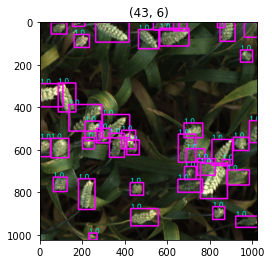

In [10]:
for batch_x, (batch_regression, batch_classification) in train_dataset_encode:
    #print(batch_x.shape, batch_regression.shape, batch_classification.shape) #(Batch Size, 1280, 1280, 3) (Batch Size, 196416, 5) (Batch Size, 196416, 2)
    x, obj_info = datasets_decode(batch_x, batch_regression, batch_classification)
    x, obj_info = x[0].numpy(), obj_info[0].numpy()
    for elem in obj_info:
        tx1, ty1, tx2, ty2, classes_idx, score = elem
        cv2.putText(x, str(round(score, 1)), (tx1, ty1), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 127, 127), 2, cv2.LINE_AA)
        cv2.rectangle(x, (tx1, ty1), (tx2, ty2), (127, 0, 127), 5)
    plt.title(str(obj_info.shape))
    plt.imshow(x)
    break

The code of building EfficientDet is copied from https://github.com/bubbliiiing/efficientdet-keras

In [11]:
def EfficientNetBN(n, input_tensor=None, input_shape=None, **kwargs):
    CONV_KERNEL_INITIALIZER = {
        'class_name': 'VarianceScaling',
        'config': {
            'scale': 2.0,
            'mode': 'fan_out',
            # EfficientNet actually uses an untruncated normal distribution for
            # initializing conv layers, but keras.initializers.VarianceScaling use
            # a truncated distribution.
            # We decided against a custom initializer for better serializability.
            'distribution': 'normal'
        }
    }

    def get_swish():
        def swish(x):
            return x * tf.math.sigmoid(x)
        return swish


    def get_dropout():
        class FixedDropout(layers.Dropout):
            def _get_noise_shape(self, inputs):
                if self.noise_shape is None:
                    return self.noise_shape
                symbolic_shape = tf.shape(inputs)
                noise_shape = [symbolic_shape[axis] if (shape is None) else shape for axis, shape in enumerate(self.noise_shape)]
                return tuple(noise_shape)
        return FixedDropout


    def round_filters(filters, width_coefficient, depth_divisor):
        filters *= width_coefficient
        new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
        new_filters = max(depth_divisor, new_filters)
        if new_filters < 0.9 * filters:
            new_filters += depth_divisor
        return int(new_filters)


    def round_repeats(repeats, depth_coefficient):
        return int(math.ceil(depth_coefficient * repeats))


    def mb_conv_block(inputs, block_args, activation, drop_rate=None, prefix='', freeze_bn=False):
        has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
        bn_axis = 3 

        Dropout = get_dropout()

        filters = block_args.input_filters * block_args.expand_ratio
        if block_args.expand_ratio != 1:
            x = layers.Conv2D(filters, 1, padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'expand_conv')(inputs)
            x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'expand_bn')(x)
            x = layers.Activation(activation, name=prefix + 'expand_activation')(x)
        else:
            x = inputs

        # Depthwise Convolution
        x = layers.DepthwiseConv2D(block_args.kernel_size, strides=block_args.strides, padding='same', use_bias=False, depthwise_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'dwconv')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'bn')(x)
        x = layers.Activation(activation, name=prefix + 'activation')(x)

        # Squeeze and Excitation phase
        if has_se:
            num_reduced_filters = max(1, int(block_args.input_filters * block_args.se_ratio))
            se_tensor = layers.GlobalAveragePooling2D(name=prefix + 'se_squeeze')(x)

            target_shape = (1, 1, filters) if backend.image_data_format() == 'channels_last' else (filters, 1, 1)
            se_tensor = layers.Reshape(target_shape, name=prefix + 'se_reshape')(se_tensor)
            se_tensor = layers.Conv2D(num_reduced_filters, 1, activation=activation, padding='same', use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'se_reduce')(se_tensor)
            se_tensor = layers.Conv2D(filters, 1, activation='sigmoid', padding='same', use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'se_expand')(se_tensor)
            if backend.backend() == 'theano':
                pattern = ([True, True, True, False] if (backend.image_data_format() == 'channels_last') else [True, False, True, True])
                se_tensor = layers.Lambda(lambda x: backend.pattern_broadcast(x, pattern), name=prefix + 'se_broadcast')(se_tensor)
            x = layers.multiply([x, se_tensor], name=prefix + 'se_excite')

        # Output phase
        x = layers.Conv2D(block_args.output_filters, 1, padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'project_conv')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'project_bn')(x)
        if block_args.id_skip and all(s == 1 for s in block_args.strides) and block_args.input_filters == block_args.output_filters:
            if drop_rate and (drop_rate > 0):
                x = Dropout(drop_rate, noise_shape=(None, 1, 1, 1), name=prefix + 'drop')(x)
            x = layers.add([x, inputs], name=prefix + 'add')
        return x


    def EfficientNet(width_coefficient, depth_coefficient, drop_connect_rate=0.2, depth_divisor=8, input_tensor=None, input_shape=None, freeze_bn=False, **kwargs):
        BlockArgs = collections.namedtuple('BlockArgs', [
            'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
            'expand_ratio', 'id_skip', 'strides', 'se_ratio'
        ])
        blocks_args = [
            BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16, expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
            BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
            BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
            BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
            BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112, expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
            BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
            BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320, expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
        ]
        
        features = []

        img_input = layers.Input(shape=input_shape) if (input_tensor is None) else (input_tensor)

        bn_axis = 3 
        activation = get_swish(**kwargs)

        # Build stem
        x = img_input
        x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name='stem_conv')(x)
        x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
        x = layers.Activation(activation, name='stem_activation')(x)
        # Build blocks
        num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
        block_num = 0
        for idx, block_args in enumerate(blocks_args):
            assert block_args.num_repeat > 0
            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, width_coefficient, depth_divisor),
                output_filters=round_filters(block_args.output_filters, width_coefficient, depth_divisor),
                num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))

            # The first block needs to take care of stride and filter size increase.
            drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
            x = mb_conv_block(x, block_args, activation=activation, drop_rate=drop_rate, prefix='block{}a_'.format(idx + 1), freeze_bn=freeze_bn)
            block_num += 1
            if block_args.num_repeat > 1:
                # pylint: disable=protected-access
                block_args = block_args._replace(
                    input_filters=block_args.output_filters, strides=[1, 1])
                # pylint: enable=protected-access
                for bidx in range(block_args.num_repeat - 1):
                    drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                    block_prefix = 'block{}{}_'.format(idx + 1, string.ascii_lowercase[bidx + 1])
                    x = mb_conv_block(x, block_args, activation=activation, drop_rate=drop_rate, prefix=block_prefix, freeze_bn=freeze_bn)
                    block_num += 1
            if idx < len(blocks_args) - 1 and blocks_args[idx + 1].strides[0] == 2:
                features.append(x)
            elif idx == len(blocks_args) - 1:
                features.append(x)
        return features

    
    parms = [
        { "width_coefficient" : 1.0, "depth_coefficient" : 1.0, "default_resolution" : 224},
        { "width_coefficient" : 1.0, "depth_coefficient" : 1.1, "default_resolution" : 240},
        { "width_coefficient" : 1.1, "depth_coefficient" : 1.2, "default_resolution" : 260},
        { "width_coefficient" : 1.2, "depth_coefficient" : 1.4, "default_resolution" : 300},
        { "width_coefficient" : 1.4, "depth_coefficient" : 1.8, "default_resolution" : 380},
        { "width_coefficient" : 1.6, "depth_coefficient" : 2.2, "default_resolution" : 456},
        { "width_coefficient" : 1.8, "depth_coefficient" : 2.6, "default_resolution" : 528},
        { "width_coefficient" : 2.0, "depth_coefficient" : 3.1, "default_resolution" : 600},
    ][n]
    return EfficientNet(parms['width_coefficient'], parms['depth_coefficient'], input_tensor=input_tensor, input_shape=input_shape, **kwargs)


#print(EfficientNetBN(7, input_shape=(600, 600, 3)))

In [12]:
from functools import reduce

import tensorflow as tf
from tensorflow.keras import *
import numpy as np

MOMENTUM = 0.99
EPSILON = 1e-3

class wBiFPNAdd(layers.Layer):
    def __init__(self, epsilon=1e-4, **kwargs):
        super(wBiFPNAdd, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        num_in = len(input_shape)
        self.w = self.add_weight(name=self.name, shape=(num_in,), initializer=initializers.constant(1 / num_in), trainable=True, dtype=tf.float32)

    def call(self, inputs, **kwargs):
        w = activations.relu(self.w)
        x = tf.reduce_sum([w[i] * inputs[i] for i in range(len(inputs))], axis=0)
        x = x / (tf.reduce_sum(w) + self.epsilon)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def get_config(self):
        config = super(wBiFPNAdd, self).get_config()
        config.update({ 'epsilon': self.epsilon })
        return config
    
    
def SeparableConvBlock(num_channels, kernel_size, strides, name, freeze_bn=False):
    f1 = layers.SeparableConv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same',
                                use_bias=True, name=f'{name}/conv')
    f2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name=f'{name}/bn')
    # f2 = BatchNormalization(freeze=freeze_bn, name=f'{name}/bn')
    return reduce(lambda f, g: lambda *args, **kwargs: g(f(*args, **kwargs)), (f1, f2))


def build_wBiFPN(features, num_channels, id, freeze_bn=False):
    if id == 0:
        _, _, C3, C4, C5 = features
        # 第一次BIFPN需要 下采样 与 降通道 获得 p3_in p4_in p5_in p6_in p7_in
        #-----------------------------下采样 与 降通道----------------------------#
        P3_in = C3
        P3_in = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                              name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/conv2d')(P3_in)
        P3_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                          name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/bn')(P3_in)

        P4_in = C4
        P4_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/conv2d')(P4_in)
        P4_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/bn')(P4_in_1)
        P4_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/conv2d')(P4_in)
        P4_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/bn')(P4_in_2)

        P5_in = C5
        P5_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/conv2d')(P5_in)
        P5_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/bn')(P5_in_1)
        P5_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/conv2d')(P5_in)
        P5_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/bn')(P5_in_2)

        P6_in = layers.Conv2D(num_channels, kernel_size=1, padding='same', name='resample_p6/conv2d')(C5)
        P6_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name='resample_p6/bn')(P6_in)
        P6_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p6/maxpool')(P6_in)

        P7_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p7/maxpool')(P6_in)
        #-------------------------------------------------------------------------#

        #--------------------------构建BIFPN的上下采样循环-------------------------#
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)
        
        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in_1, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in_1, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)

        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in_2, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)

        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in_2, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)

        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)

        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)

    else:
        P3_in, P4_in, P5_in, P6_in, P7_in = features
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)

        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)

        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)

        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)

        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)

        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)

    return [P3_out, P4_out, P5_out, P6_out, P7_out]

def build_BiFPN(features, num_channels, id, freeze_bn=False):
    if id == 0:
        # 第一次BIFPN需要 下采样 与 降通道 获得 p3_in p4_in p5_in p6_in p7_in
        #-----------------------------下采样 与 降通道----------------------------#
        _, _, C3, C4, C5 = features
        P3_in = C3
        P3_in = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                              name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/conv2d')(P3_in)
        P3_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                          name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/bn')(P3_in)

        P4_in = C4
        P4_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/conv2d')(P4_in)
        P4_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/bn')(P4_in_1)
        P4_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/conv2d')(P4_in)
        P4_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/bn')(P4_in_2)

        P5_in = C5
        P5_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/conv2d')(P5_in)
        P5_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/bn')(P5_in_1)
        P5_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/conv2d')(P5_in)
        P5_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/bn')(P5_in_2)

        P6_in = layers.Conv2D(num_channels, kernel_size=1, padding='same', name='resample_p6/conv2d')(C5)
        P6_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name='resample_p6/bn')(P6_in)
        P6_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p6/maxpool')(P6_in)

        P7_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p7/maxpool')(P6_in)
        #-------------------------------------------------------------------------#

        #--------------------------构建BIFPN的上下采样循环-------------------------#
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)

        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in_1, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in_1, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)

        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in_2, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)

        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in_2, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)

        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)

        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)

    else:
        P3_in, P4_in, P5_in, P6_in, P7_in = features
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)

        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)

        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)

        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)

        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)

        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)
    return [P3_out, P4_out, P5_out, P6_out, P7_out]

class PriorProbability(initializers.Initializer):
    """ Apply a prior probability to the weights.
    """

    def __init__(self, probability=0.01):
        self.probability = probability

    def get_config(self):
        return {
            'probability': self.probability
        }

    def __call__(self, shape, dtype=None):
        # set bias to -log((1 - p)/p) for foreground
        result = np.ones(shape) * -math.log((1 - self.probability) / self.probability)

        return result

    
class BoxNet:
    def __init__(self, width, depth, num_anchors=9, freeze_bn=False, name='box_net', **kwargs):
        self.name = name
        self.width = width
        self.depth = depth
        self.num_anchors = num_anchors
        options = {
            'kernel_size': 3,
            'strides': 1,
            'padding': 'same',
            'bias_initializer': 'zeros',
            'depthwise_initializer': initializers.VarianceScaling(),
            'pointwise_initializer': initializers.VarianceScaling(),
        }

        self.convs = [layers.SeparableConv2D(filters=width, name=f'{self.name}/box-{i}', **options) for i in range(depth)]
        self.head = layers.SeparableConv2D(filters=num_anchors * 4, name=f'{self.name}/box-predict', **options)

        self.bns = [
            [layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name=f'{self.name}/box-{i}-bn-{j}') for j in
             range(3, 8)]
            for i in range(depth)]

        self.relu = layers.Lambda(lambda x: tf.nn.swish(x))
        self.reshape = layers.Reshape((-1, 4))

    def call(self, inputs):
        feature, level = inputs
        for i in range(self.depth):
            feature = self.convs[i](feature)
            feature = self.bns[i][level](feature)
            feature = self.relu(feature)
        outputs = self.head(feature)
        outputs = self.reshape(outputs)
        return outputs


class ClassNet:
    def __init__(self, width, depth, num_classes=20, num_anchors=9, freeze_bn=False, name='class_net', **kwargs):
        self.name = name
        self.width = width
        self.depth = depth
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        options = {
            'kernel_size': 3,
            'strides': 1,
            'padding': 'same',
            'depthwise_initializer': initializers.VarianceScaling(),
            'pointwise_initializer': initializers.VarianceScaling(),
        }

        self.convs = [layers.SeparableConv2D(filters=width, bias_initializer='zeros', name=f'{self.name}/class-{i}', **options) for i in range(depth)]
        self.head = layers.SeparableConv2D(filters=num_classes * num_anchors, bias_initializer=PriorProbability(probability=0.01), name=f'{self.name}/class-predict', **options)
        self.bns = [[layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name=f'{self.name}/class-{i}-bn-{j}') for j in range(3, 8)] for i in range(depth)]
        self.relu = layers.Lambda(lambda x: tf.nn.swish(x))
        self.reshape = layers.Reshape((-1, num_classes))
        self.activation = layers.Activation('sigmoid')

    def call(self, inputs):
        feature, level = inputs
        for i in range(self.depth):
            feature = self.convs[i](feature)
            feature = self.bns[i][level](feature)
            feature = self.relu(feature)
        outputs = self.head(feature)
        outputs = self.reshape(outputs)
        outputs = self.activation(outputs)
        return outputs

def Efficientdet(phi, num_classes=20, num_anchors=9, freeze_bn=False):
    assert phi in range(8)
    fpn_num_filters = [64, 88, 112, 160, 224, 288, 384,384]
    fpn_cell_repeats = [3, 4, 5, 6, 7, 7, 8, 8]
    box_class_repeats = [3, 3, 3, 4, 4, 4, 5, 5]
    image_sizes = [512, 640, 768, 896, 1024, 1280, 1408, 1536]
    backbones = EfficientNetBN

    input_size = image_sizes[phi]
    input_shape = (input_size, input_size, 3)
    image_input = layers.Input(input_shape)

    features = backbones(phi, input_tensor=image_input, freeze_bn=freeze_bn)
    fpn_features = features
    if phi < 6:
        for i in range(fpn_cell_repeats[phi]):
            fpn_features = build_wBiFPN(fpn_features, fpn_num_filters[phi], i, freeze_bn=freeze_bn)
    else:        
        for i in range(fpn_cell_repeats[phi]):
            fpn_features = build_BiFPN(fpn_features, fpn_num_filters[phi], i, freeze_bn=freeze_bn)

    box_net = BoxNet(fpn_num_filters[phi], box_class_repeats[phi], num_anchors=num_anchors, freeze_bn=freeze_bn, name='box_net')
    class_net = ClassNet(fpn_num_filters[phi], box_class_repeats[phi], num_classes=num_classes, num_anchors=num_anchors, freeze_bn=freeze_bn, name='class_net')
    
    classification = [class_net.call([feature, i]) for i, feature in enumerate(fpn_features)]
    classification = layers.Concatenate(axis=1, name='classification')(classification)
    regression = [box_net.call([feature, i]) for i, feature in enumerate(fpn_features)]
    regression = layers.Concatenate(axis=1, name='regression')(regression)

    model = models.Model(inputs=[image_input], outputs=[regression,classification], name='efficientdet')

    return model

#Efficientdet(5, num_classes=1).summary()

In [13]:
# classification
def focal(alpha=0.25, gamma=2.0):
    def _focal(y_true, y_pred):
        # print(y_true.shape, y_pred.shape)
        # y_true [batch_size, num_anchor, num_classes+1]
        # y_pred [batch_size, num_anchor, num_classes]
        labels         = y_true[:, :, :-1]
        anchor_state   = y_true[:, :, -1]  # -1: ignrore, 0: background, 1: object
        classification = y_pred


        # Focal Loss for postive sample (Object)
        indices_for_object        = tf.where(tf.equal(anchor_state, 1))
        labels_for_object         = tf.gather_nd(labels, indices_for_object)
        classification_for_object = tf.gather_nd(classification, indices_for_object)

        alpha_factor_for_object = tf.ones_like(labels_for_object) * alpha
        alpha_factor_for_object = tf.where(tf.equal(labels_for_object, 1), alpha_factor_for_object, 1 - alpha_factor_for_object)
        focal_weight_for_object = tf.where(tf.equal(labels_for_object, 1), 1 - classification_for_object, classification_for_object)
        focal_weight_for_object = alpha_factor_for_object * focal_weight_for_object ** gamma

        cls_loss_for_object = focal_weight_for_object * backend.binary_crossentropy(labels_for_object, classification_for_object)
        cls_loss_for_object = tf.reduce_sum(cls_loss_for_object)
            
        # Focal Loss for negative sample (Background)
        indices_for_back        = tf.where(tf.equal(anchor_state, 0))
        labels_for_back         = tf.gather_nd(labels, indices_for_back)
        classification_for_back = tf.gather_nd(classification, indices_for_back)

        alpha_factor_for_back = tf.ones_like(labels_for_back) * (1 - alpha)
        focal_weight_for_back = classification_for_back
        focal_weight_for_back = alpha_factor_for_back * focal_weight_for_back ** gamma

        cls_loss_for_back = focal_weight_for_back * backend.binary_crossentropy(labels_for_back, classification_for_back)
        cls_loss_for_back = tf.reduce_sum(cls_loss_for_back)

        # num of postive sample (Object) 
        normalizer = tf.where(tf.equal(anchor_state, 1))
        normalizer = tf.cast(tf.shape(normalizer)[0], tf.float32)
        normalizer = tf.maximum(normalizer, 1.0)


        # totoal loss
        loss = (cls_loss_for_object + cls_loss_for_back) / normalizer  # norm by num of postive samples
        return loss
    return _focal

# regression
def smooth_l1(sigma=3.0):
    sigma_squared = sigma ** 2

    def _smooth_l1(y_true, y_pred):
        # print(y_true.shape, y_pred.shape)
        # y_true [batch_size, num_anchor, 5]
        # y_pred [batch_size, num_anchor, 4]
        
        regression        = y_pred
        regression_target = y_true[:, :, :-1]
        anchor_state      = y_true[:, :, -1]

        # Select postive samples
        indices           = tf.where(tf.equal(anchor_state, 1))
        regression        = tf.gather_nd(regression, indices)
        regression_target = tf.gather_nd(regression_target, indices)

        # compute smooth L1 loss
        # f(x) = 0.5 * (sigma * x)^2   if |x| < 1 / sigma / sigma
        # |x| - 0.5 / sigma / sigma    otherwise
        regression_diff = regression - regression_target
        regression_diff = tf.abs(regression_diff)
        regression_loss = tf.where(regression_diff <= (1.0 / sigma_squared), 0.5 * sigma_squared * tf.math.pow(regression_diff, 2), regression_diff - 0.5 / sigma_squared)

        # compute the normalizer: the number of positive anchors
        normalizer = tf.maximum(tf.shape(indices)[0], 1)
        normalizer = tf.cast(normalizer, tf.float32)
        return tf.reduce_sum(regression_loss) / normalizer / 4

    return _smooth_l1

In [14]:
def load_model_weights(file_path=None):
    initial_epoch, initial_learning_rate, initial_model = 0, 1e-3, None
    file_paths = []
    if file_path == None:
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                if(filename.endswith('.h5')):
                    file_paths.append(os.path.join(dirname, filename))
    else:
        file_paths.append(file_path)
    for file_path in file_paths:
        epoch, _, _, _, learning_rate = os.path.splitext(os.path.basename(file_path))[0].split('_')[1:]
        epoch = int(epoch)
        learning_rate = float(learning_rate)
        if epoch >= initial_epoch:
            initial_epoch, initial_learning_rate, initial_model = epoch, learning_rate, file_path
    return initial_epoch, initial_learning_rate, initial_model

initial_epoch, initial_learning_rate, initial_model = load_model_weights()
print(initial_epoch, initial_learning_rate, initial_model)

19 0.0001 /kaggle/input/wheat-model-1/model_19_0.1601_0.0335_0.1266_0.00010.h5


In [15]:
with strategy.scope():
    model = Efficientdet(PHI, num_classes=NUM_CLASSES)
    model.compile(loss={ 'regression' : smooth_l1(), 'classification': focal() }, optimizer=keras.optimizers.Adam(initial_learning_rate)) #metrics=[mIOU]
    model.load_weights(initial_model, by_name=True, skip_mismatch=True)

In [16]:
def cosineAnnealingWithWarmup(epochIdx):
    aMax, aMin = 5e-4, 6.25e-5
    warmupEpochs, stagnateEpochs, cosAnnealingEpochs = 2, 0, 8
    epochIdx = epochIdx % (warmupEpochs + stagnateEpochs + cosAnnealingEpochs)
    if(epochIdx < warmupEpochs):
        return aMin + (aMax - aMin) / (warmupEpochs - 1) * epochIdx
    else:
        epochIdx -= warmupEpochs
    if(epochIdx < stagnateEpochs):
        return aMax
    else:
        epochIdx -= stagnateEpochs
    return aMin + 0.5 * (aMax - aMin) * (1 + math.cos((epochIdx + 1) / (cosAnnealingEpochs + 1) * math.pi))

#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.5, mode='auto')
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(tf.keras.experimental.CosineDecayRestarts(5e-5, 10), verbose=1)
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(cosineAnnealingWithWarmup, verbose=1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, verbose=1)

In [17]:
class custimzed_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        loss, loss_classification, loss_regression  = model.evaluate(valid_dataset_encode, steps=VALID_STEPS_PER_EPOCH)
        model.save_weights("model_{:.0f}_{:.4f}_{:.4f}_{:.4f}_{:.5f}.h5".format(float(epoch + 1), loss, loss_classification, loss_regression, self.model.optimizer.learning_rate.numpy()))

In [18]:
It is slow to start training (Be patient for waiting 10 minutes).

SyntaxError: invalid syntax (<ipython-input-18-329ede7aca2d>, line 1)

In [19]:
Epoch = 25

callbacks_list = [lr_schedule, custimzed_callback()]

model.fit(train_dataset_encode, epochs=Epoch, callbacks=callbacks_list, initial_epoch = initial_epoch, steps_per_epoch=TRAIN_STEPS_PER_EPOCH)

Epoch 20/25
85/85 [==============================] - 367s 4s/step - classification_loss: 0.1235 - regression_loss: 0.0337 - loss: 0.1572 - lr: 1.0000e-04
Epoch 21/25
85/85 [==============================] - 338s 4s/step - classification_loss: 0.1192 - regression_loss: 0.0328 - loss: 0.1520 - lr: 1.0000e-04
Epoch 22/25
85/85 [==============================] - 340s 4s/step - classification_loss: 0.1193 - regression_loss: 0.0329 - loss: 0.1522 - lr: 1.0000e-04
Epoch 23/25
85/85 [==============================] - 343s 4s/step - classification_loss: 0.1172 - regression_loss: 0.0324 - loss: 0.1496 - lr: 1.0000e-04
Epoch 24/25
85/85 [==============================] - 344s 4s/step - classification_loss: 0.1158 - regression_loss: 0.0321 - loss: 0.1479 - lr: 1.0000e-04
Epoch 25/25
85/85 [==============================] - 344s 4s/step - classification_loss: 0.1142 - regression_loss: 0.0318 - loss: 0.1460 - lr: 1.0000e-04


Test

Inference Started:  11:00:32
Datasets Loaded:  11:00:38
Prediction Finish:  11:02:44
Decode Prediction Finish:  11:02:46


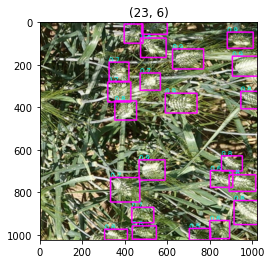

In [20]:

from datetime import datetime

def print_time(title):
    print(title + ": ", datetime.now().strftime("%H:%M:%S"))

print_time("Inference Started")
for batch_x, _ in valid_dataset_encode:
    print_time("Datasets Loaded")
    batch_regression, batch_classification = model.predict(batch_x)
    print_time("Prediction Finish")
    #print(batch_x.shape, batch_regression.shape, batch_classification.shape) #(Batch Size, 1280, 1280, 3) (Batch Size, 196416, 5) (Batch Size, 196416, 2)
    x, obj_info = datasets_decode(batch_x, batch_regression, batch_classification)
    print_time("Decode Prediction Finish")
    x, obj_info = x[0].numpy(), obj_info[0].numpy()
    for elem in obj_info:
        tx1, ty1, tx2, ty2, classes_idx, score = elem
        cv2.putText(x, str(round(score, 1)), (tx1, ty1), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 127, 127), 2, cv2.LINE_AA)
        cv2.rectangle(x, (tx1, ty1), (tx2, ty2), (127, 0, 127), 5)
    plt.title(str(obj_info.shape))
    plt.imshow(x)
    break